In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time

from itertools import izip, combinations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

**Keep testing functions here**

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Mini       104280
Router     103593
Dropcam     64568
Kasa        23753
Netcam3      4867
Netcam1      4446
Netcam2      4407
Switch2      3046
Switch1      2668
Switch3      2634
Insight      2556
Switch4      2206
Lifx2         627
TpPlug        587
Lifx1         540
TpBulb        202
Name: Name, dtype: int64


**Prep dataframe**

In [15]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

**Plot dataframe**

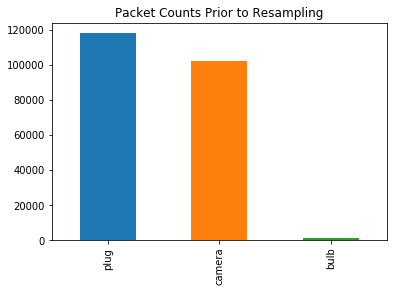

In [16]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#

devtype_df = df["DeviceType"].value_counts()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

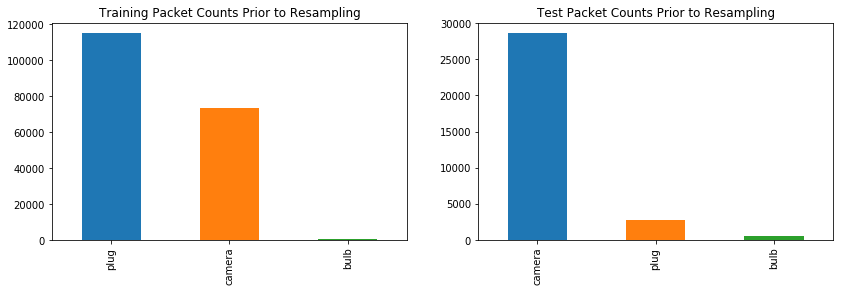

In [17]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
devtype_train = df_train["DeviceType"].value_counts()
plt.subplot(1, 2, 1) #
devtype_train.plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
devtype_test = df_test["DeviceType"].value_counts()
plt.subplot(1, 2, 2)
devtype_test.plot(kind='bar', title="Test Packet Counts Prior to Resampling");


**Resampling**

Undersampling DeviceType

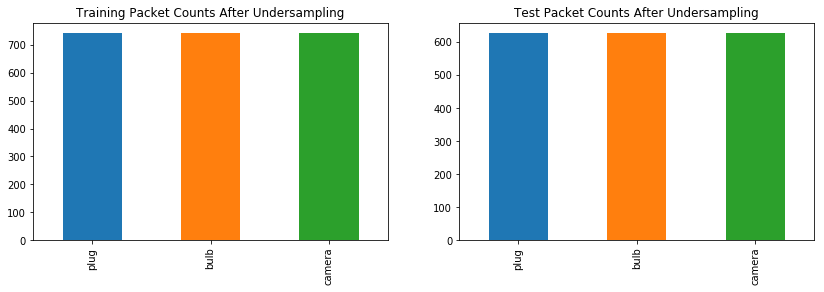

In [18]:
# 1st technique - Random undersampling: 
#     randomly removing packets of the majority classes to match the minority class

kind = "under"
category = "DeviceType"
df_train_undersampled = w.resample(df_train, kind=kind, category=category)
df_test_undersampled = w.resample(df_test, kind=kind, category=category)

# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Undersampling");

plt.subplot(1, 2, 2)
df_test_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Undersampling");

Oversampling DeviceType

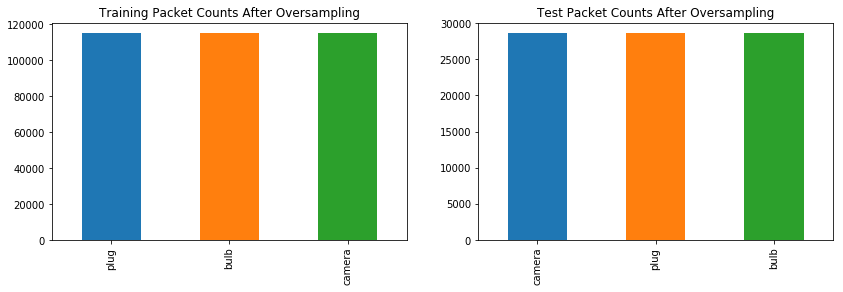

In [19]:
# 2nd technique - Random oversampling: 
#     randomly resampling packets of the minority classes to match the count of the majority class
kind = "over"
category = "DeviceType"
df_train_oversampled = w.resample(df_train, kind=kind, category=category)
df_test_oversampled = w.resample(df_test, kind=kind, category=category)


# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Oversampling");

plt.subplot(1, 2, 2)
df_test_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Oversampling");

Undersampling and Oversampling Name

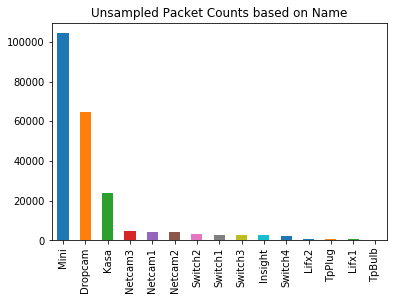

In [20]:
# Another resampling. This time using Name as the category

# First: plot the unsampled df
df["Name"].value_counts().plot(kind='bar', title="Unsampled Packet Counts based on Name");

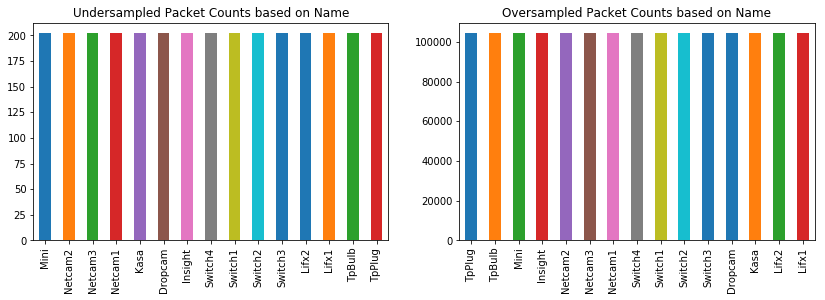

In [21]:
category = "Name"
df_name_undersample = w.resample(df, kind="under", category=category)
df_name_oversample = w.resample(df, kind="over", category=category)

plt.subplots(1, 2, figsize=(14,4))
plt.subplot(1, 2, 1)
df_name_undersample["Name"].value_counts().plot(kind='bar', title="Undersampled Packet Counts based on Name");
plt.subplot(1, 2, 2)
df_name_oversample["Name"].value_counts().plot(kind='bar', title="Oversampled Packet Counts based on Name");

**Create feature list**

In [22]:
# Run One vs All  and One vs One classification strategies
features_list = [
        # Packet info
        "PacketLength", "Duration", 
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

y_list = ["camera", "bulb", "plug"]

Running classification

Undersampling and Oversampling by DeviceType

In [22]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs one: undersampling by DeviceType\n"
# test_one_vs_one_classify(df_undersample, features_list, y_list)
onevone_under_devtype = w.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by DeviceType

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        627       0
camera        2     625 

RF Metrics
        FN  FP   TN   TP  Accuracy  Precision   Recall
bulb     0   2  625  627  0.998405    0.99682  1.00000
camera   2   0  627  625  0.998405    1.00000  0.99681 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        626       1
camera       23     604 

KNN Metrics
        FN  FP   TN   TP  Accuracy  Precision    Recall
bulb     1  23  604  626  0.980861   0.964561  0.998405
camera  23   1  626  604  0.980861   0.998347  0.963317 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        627       0
camera      175     452 

LDA Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
bulb      0  175  452  627  0.860

In [23]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs all: undersampling by DeviceType\n"
# test_one_vs_all_classify(df_undersample, features_list, y_list)
one_under_devtype = w.one_vs_all_classify(df_undersample, features_list, y_list)

One vs all: undersampling by DeviceType

Device Type: camera
--------------------------
--------------------------
RF Confusion Matrix
Predicted  camera  rest
Actual                 
camera         71   556
rest           71  1183 

RF Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  556   71  1183    71  0.666667   0.500000  0.113238
rest     71  556    71  1183  0.666667   0.680276  0.943381 

--------------------------
KNN Confusion Matrix
Predicted  camera  rest
Actual                 
camera        196   431
rest          208  1046 

KNN Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  431  208  1046   196  0.660287   0.485149  0.312600
rest    208  431   196  1046  0.660287   0.708192  0.834131 

--------------------------
LDA Confusion Matrix
Predicted  camera  rest
Actual                 
camera         30   597
rest           35  1219 

LDA Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  597   35

{'bulb': {'KNN': {'CM': Predicted  bulb  rest
   Actual               
   bulb        626     1
   rest         15  1239,
   'Metrics':       FN  FP    TN    TP  Accuracy  Precision    Recall
   bulb   1  15  1239   626  0.991494   0.976599  0.998405
   rest  15   1   626  1239  0.991494   0.999194  0.988038},
  'LDA': {'CM': Predicted  bulb  rest
   Actual               
   bulb        627     0
   rest        236  1018,
   'Metrics':        FN   FP    TN    TP  Accuracy  Precision    Recall
   bulb    0  236  1018   627  0.874535   0.726535  1.000000
   rest  236    0   627  1018  0.874535   1.000000  0.811802},
  'RF': {'CM': Predicted  bulb  rest
   Actual               
   bulb        627     0
   rest          3  1251,
   'Metrics':       FN  FP    TN    TP  Accuracy  Precision    Recall
   bulb   0   3  1251   627  0.998405   0.995238  1.000000
   rest   3   0   627  1251  0.998405   1.000000  0.997608}},
 'camera': {'KNN': {'CM': Predicted  camera  rest
   Actual               

In [24]:
df_oversample = pd.concat([df_train_oversampled, df_test_oversampled], axis=0)
print "One vs one: oversampling by DeviceType\n"
# test_one_vs_one_classify(df_oversample, features_list, y_list)
w.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by DeviceType

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb       28620       0
camera      1375   27245 

RF Metrics
          FN    FP     TN     TP  Accuracy  Precision    Recall
bulb       0  1375  27245  28620  0.975978   0.954159  1.000000
camera  1375     0  28620  27245  0.975978   1.000000  0.951957 

--------------------------
KNN Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb       28277     343
camera         6   28614 

KNN Metrics
         FN   FP     TN     TP  Accuracy  Precision    Recall
bulb    343    6  28614  28277  0.993903   0.999788  0.988015
camera    6  343  28277  28614  0.993903   0.988155  0.999790 

--------------------------
LDA Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb       28620       0
camera      8164   20456 

LDA Metrics
          FN    FP     TN     TP  A

{('bulb', 'plug'): {'KNN': {'CM': Predicted   bulb   plug
   Actual                 
   bulb       28341    279
   plug        5988  22632,
   'Metrics':         FN    FP     TN     TP  Accuracy  Precision    Recall
   bulb   279  5988  22632  28341  0.890514   0.825570  0.990252
   plug  5988   279  28341  22632  0.890514   0.987822  0.790776},
  'LDA': {'CM': Predicted   bulb   plug
   Actual                 
   bulb       28620      0
   plug        7657  20963,
   'Metrics':         FN    FP     TN     TP  Accuracy  Precision   Recall
   bulb     0  7657  20963  28620   0.86623    0.78893  1.00000
   plug  7657     0  28620  20963   0.86623    1.00000  0.73246},
  'RF': {'CM': Predicted   bulb   plug
   Actual                 
   bulb       28620      0
   plug        5998  22622,
   'Metrics':         FN    FP     TN     TP  Accuracy  Precision    Recall
   bulb     0  5998  22622  28620  0.895213   0.826738  1.000000
   plug  5998     0  28620  22622  0.895213   1.000000  0.79042

In [25]:
print "One vs all: oversampling by DeviceType\n"
all_over_devtype = w.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by DeviceType

Device Type: camera
--------------------------
--------------------------
RF Confusion Matrix
Predicted  camera   rest
Actual                  
camera       4301  24319
rest         3131  54109 

RF Metrics
           FN     FP     TN     TP  Accuracy  Precision   Recall
camera  24319   3131  54109   4301  0.680294   0.578714  0.15028
rest     3131  24319   4301  54109  0.680294   0.689919  0.94530 

--------------------------
KNN Confusion Matrix
Predicted  camera   rest
Actual                  
camera       7986  20634
rest         3429  53811 

KNN Metrics
           FN     FP     TN     TP  Accuracy  Precision    Recall
camera  20634   3429  53811   7986  0.719741   0.699606  0.279036
rest     3429  20634   7986  53811  0.719741   0.722829  0.940094 

--------------------------
LDA Confusion Matrix
Predicted  camera   rest
Actual                  
camera       1840  26780
rest         1659  55581 

LDA Metrics
           FN     FP     TN     

{'bulb': {'KNN': {'CM': Predicted   bulb   rest
   Actual                 
   bulb       28190    430
   rest        5991  51249,
   'Metrics':         FN    FP     TN     TP  Accuracy  Precision    Recall
   bulb   430  5991  51249  28190  0.925215   0.824727  0.984976
   rest  5991   430  28190  51249  0.925215   0.991679  0.895335},
  'LDA': {'CM': Predicted   bulb   rest
   Actual                 
   bulb       28620      0
   rest       10365  46875,
   'Metrics':          FN     FP     TN     TP  Accuracy  Precision   Recall
   bulb      0  10365  46875  28620   0.87928   0.734129  1.00000
   rest  10365      0  28620  46875   0.87928   1.000000  0.81892},
  'RF': {'CM': Predicted   bulb   rest
   Actual                 
   bulb       28620      0
   rest         130  57110,
   'Metrics':        FN   FP     TN     TP  Accuracy  Precision    Recall
   bulb    0  130  57110  28620  0.998486   0.995478  1.000000
   rest  130    0  28620  57110  0.998486   1.000000  0.997729}},
 'cam

Undersampling and Oversampling by Name

In [26]:
df_undersample = df_name_undersample
print "One vs one: undersampling by Name\n"
one_under_name = w.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by Name

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        202       0
camera        0     404 

RF Metrics
        FN  FP   TN   TP  Accuracy  Precision  Recall
bulb     0   0  404  202       1.0        1.0     1.0
camera   0   0  202  404       1.0        1.0     1.0 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        202       0
camera        0     404 

KNN Metrics
        FN  FP   TN   TP  Accuracy  Precision  Recall
bulb     0   0  404  202       1.0        1.0     1.0
camera   0   0  202  404       1.0        1.0     1.0 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        181      21
camera        2     402 

LDA Metrics
        FN  FP   TN   TP  Accuracy  Precision   Recall
bulb    21   2  402  181  0.962046   0.989071  0.89

{('bulb', 'plug'): {'KNN': {'CM': Predicted  bulb  plug
   Actual               
   bulb        202     0
   plug        202   202,
   'Metrics':        FN   FP   TN   TP  Accuracy  Precision  Recall
   bulb    0  202  202  202  0.666667        0.5     1.0
   plug  202    0  202  202  0.666667        1.0     0.5},
  'LDA': {'CM': Predicted  bulb  plug
   Actual               
   bulb        202     0
   plug         23   381,
   'Metrics':       FN  FP   TN   TP  Accuracy  Precision    Recall
   bulb   0  23  381  202  0.962046   0.897778  1.000000
   plug  23   0  202  381  0.962046   1.000000  0.943069},
  'RF': {'CM': Predicted  bulb  plug
   Actual               
   bulb        202     0
   plug        202   202,
   'Metrics':        FN   FP   TN   TP  Accuracy  Precision  Recall
   bulb    0  202  202  202  0.666667        0.5     1.0
   plug  202    0  202  202  0.666667        1.0     0.5}},
 ('camera', 'bulb'): {'KNN': {'CM': Predicted  bulb  camera
   Actual                 
 

In [27]:
print "One vs All: undersampling by Name\n"
all_under_name = w.one_vs_all_classify(df_undersample, features_list, y_list)

One vs All: undersampling by Name

Device Type: camera
--------------------------
--------------------------
RF Confusion Matrix
Predicted  camera  rest
Actual                 
camera        172   232
rest          210   396 

RF Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
camera  232  210  396  172  0.562376   0.450262  0.425743
rest    210  232  172  396  0.562376   0.630573  0.653465 

--------------------------
KNN Confusion Matrix
Predicted  camera  rest
Actual                 
camera        139   265
rest          197   409 

KNN Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
camera  265  197  409  139  0.542574   0.413690  0.344059
rest    197  265  139  409  0.542574   0.606825  0.674917 

--------------------------
LDA Confusion Matrix
Predicted  camera  rest
Actual                 
camera         83   321
rest           14   592 

LDA Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
camera  321   14  592   83  0.668317

{'bulb': {'KNN': {'CM': Predicted  bulb  rest
   Actual               
   bulb        202     0
   rest          9   799,
   'Metrics':       FN  FP   TN   TP  Accuracy  Precision    Recall
   bulb   0   9  799  202  0.991089   0.957346  1.000000
   rest   9   0  202  799  0.991089   1.000000  0.988861},
  'LDA': {'CM': Predicted  bulb  rest
   Actual               
   bulb        181    21
   rest          9   799,
   'Metrics':       FN  FP   TN   TP  Accuracy  Precision    Recall
   bulb  21   9  799  181  0.970297   0.952632  0.896040
   rest   9  21  181  799  0.970297   0.974390  0.988861},
  'RF': {'CM': Predicted  bulb  rest
   Actual               
   bulb        202     0
   rest        201   607,
   'Metrics':        FN   FP   TN   TP  Accuracy  Precision    Recall
   bulb    0  201  607  202   0.80099   0.501241  1.000000
   rest  201    0  202  607   0.80099   1.000000  0.751238}},
 'camera': {'KNN': {'CM': Predicted  camera  rest
   Actual                 
   camera      

In [23]:
df_oversample = df_name_oversample
print "One vs one: oversampling by Name\n"
one_over_name = w.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by Name

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted    bulb  camera
Actual                   
bulb       104280       0
camera      30134  178426 

RF Metrics
           FN     FP      TN      TP  Accuracy  Precision    Recall
bulb        0  30134  178426  104280  0.903676   0.775812  1.000000
camera  30134      0  104280  178426  0.903676   1.000000  0.855514 

--------------------------
KNN Confusion Matrix
Predicted    bulb  camera
Actual                   
bulb       103230    1050
camera         32  208528 

KNN Metrics
          FN    FP      TN      TP  Accuracy  Precision    Recall
bulb    1050    32  208528  103230  0.996541    0.99969  0.989931
camera    32  1050  103230  208528  0.996541    0.99499  0.999847 

--------------------------
LDA Confusion Matrix
Predicted    bulb  camera
Actual                   
bulb       104280       0
camera      36020  172540 

LDA Metrics
     

In [24]:
print "One vs all: oversampling by Name\n"
all_over_name = w.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by Name

Device Type: camera
--------------------------
--------------------------
RF Confusion Matrix
Predicted  camera    rest
Actual                   
camera      88883  119677
rest         8724  304116 

RF Metrics
            FN      FP      TN      TP  Accuracy  Precision    Recall
camera  119677    8724  304116   88883  0.753738   0.910621  0.426175
rest      8724  119677   88883  304116  0.753738   0.717605  0.972114 

--------------------------
KNN Confusion Matrix
Predicted  camera    rest
Actual                   
camera      36685  171875
rest         2077  310763 

KNN Metrics
            FN      FP      TN      TP  Accuracy  Precision    Recall
camera  171875    2077  310763   36685  0.666375   0.946417  0.175897
rest      2077  171875   36685  310763  0.666375   0.643884  0.993361 

--------------------------
LDA Confusion Matrix
Predicted  camera    rest
Actual                   
camera      40641  167919
rest         8021  304819 

LDA Metrics